# Population Branch Statistics (PBS)

In [1]:
%run "imports.ipynb"

In [2]:
ac_biallel = zarr.open('data/phase2_biallel_allele_count.zarr')
outgroup_allele_counts= zarr.open('data/outgroup_alleles_phase2.zarr')
callset = callset_biallel

In [3]:
contigs = ['2R','2L','3R','3L', 'X']

In [53]:
np.set_printoptions(threshold=sys.maxsize)

----------------------------------------------

In [22]:
def pbs(chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    
    # load variant positions
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    pos = callset[chrom]['variants/POS'][:][loc_pass_variants]
    
    # load allele counts
    ac1 = allel.AlleleCountsArray(ac_biallel[chrom][pop1])
    ac2 = allel.AlleleCountsArray(ac_biallel[chrom][pop2])
    ac3 = allel.AlleleCountsArray(outgroup_allele_counts[chrom][pop3])

    # locate segregating variants at sufficient frequency
    ac = ac1 + ac2 + ac3
    loc_seg = (ac.to_frequencies()[:, :2].min(axis=1) > min_maf)
    pos = pos[loc_seg]
    ac1 = ac1[loc_seg]
    ac2 = ac2[loc_seg]
    ac3 = ac3[loc_seg]
    
    # setup windows
    starts = allel.moving_statistic(pos, statistic=lambda v: v[0], size=window_size)
    starts[0] = 1  # fix to start of sequence
    ends = np.append(starts[1:] - 1, [np.max(pos)])

    # compute pbs
    res = allel.pbs(ac1, ac2, ac3, window_size=window_size, normed=normed)

    return starts, ends, res

def pbs_plot (chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    starts, ends, y = pbs(chrom, pop1, pop2, pop3)
    fig, ax = plt.subplots(figsize=(14, 3))
    x = (starts + ends) / 2
    sns.despine(ax=ax, offset=10)
    ax.set_xlim(0, x.max())
    ax.plot(x, y, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
    ax.set_xlabel('Genome position (bp)')
    ax.set_ylabel('PBS');
    
def plot_genes_remastered(chrom, pos):
    plot_genes(genome, geneset_fn, chrom, pos-100, pos+100, label=True, label_rotation=90, height=0.5)
    
def plot_genes_pbs(chrom, pop1, pop2, pop3):
    
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > 0.2]
    print (over30)
    for i in range(len(over30)):
        plt.figure()
        plot_genes_remastered(chrom, over30[i])
    

## PBS by sympatric populations using <i>An.arabiensis</i> population as outgroup

### Chromosome 3R

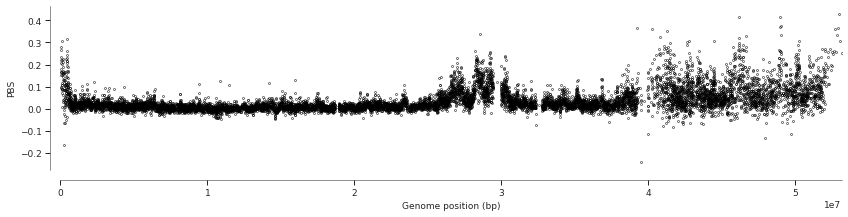

In [15]:
pbs_plot('3R', 'BFcol', 'BFgam', 'arab')

------------------------------

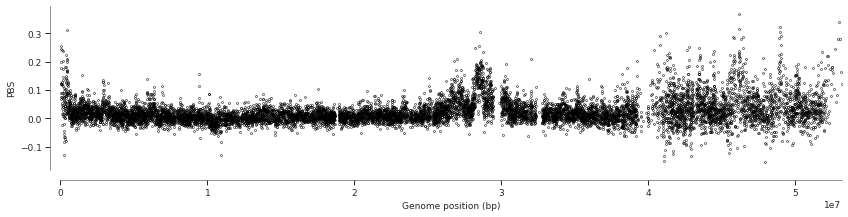

In [16]:
pbs_plot('3R', 'GHcol', 'GHgam', 'arab')

-------------------

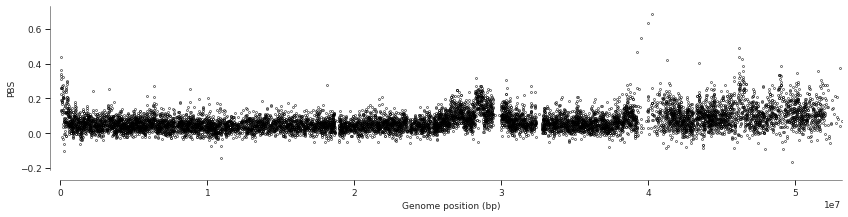

In [17]:
pbs_plot('3R', 'GNcol', 'GNgam', 'arab')

## PBS by ecotype

Forest vs Sahel vs Island:

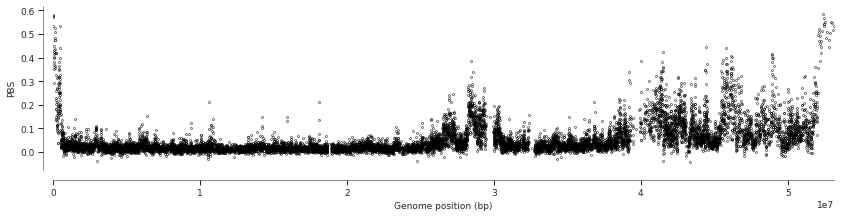

In [9]:
pbs_plot('3R','GHcol', 'BFgam', 'FRgam')

Mangroves vs Mangroves vs Island:

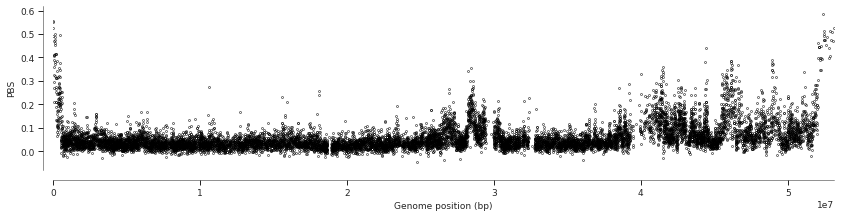

In [10]:
pbs_plot('3R','GHcol', 'GAgam', 'FRgam')

Mangroves vs Mangroves vs Island:

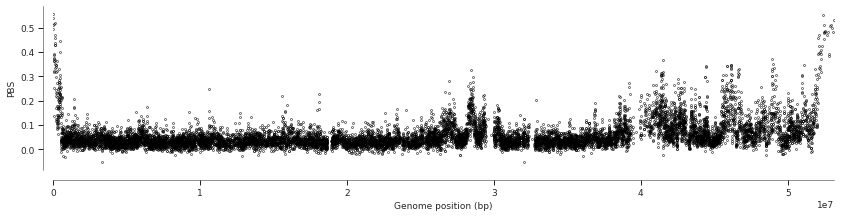

In [11]:
pbs_plot('3R','CIcol', 'GAgam', 'FRgam')

-------------------------------------

## Sandbox - First time

In [12]:
pop_select = metadata.population.isin({'BFgam', 'BFcol', 'AOcol'}).values
pop_subset=metadata[pop_select]

In [13]:
genotypes_phase2_call = callset_phase2['3L']["calldata/GT"]
genotypes_phase2_call

<zarr.core.Array '/3L/calldata/GT' (10640388, 1142, 2) int8 read-only>

In [14]:
pos = allel.SortedIndex(callset_phase2["3L"]["variants/POS"])
pos

0,1,2,3,4,...,10640383,10640384,10640385,10640386,10640387
9790,9791,9798,9812,9815,...,41956532,41956537,41956541,41956551,41956556


In [15]:
genotypes_phase2 = allel.GenotypeDaskArray(genotypes_phase2_call)
genotypes_phase2

<GenotypeDaskArray shape=(10640388, 1142, 2) dtype=int8>

In [16]:
geno_p2_subset = genotypes_phase2.subset(sel1=pop_select)
geno_p2_subset

<GenotypeDaskArray shape=(10640388, 245, 2) dtype=int8>

In [17]:
grp = pop_subset.groupby("population")
grp_indices = grp.indices
ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)

In [18]:
pbs = allel.pbs(ac_subpops['BFcol'], ac_subpops['BFgam'], ac_subpops['AOcol'], 1000)

In [22]:
x = allel.moving_statistic(pos, statistic=lambda v: v[0], size=1000)

In [23]:
len(x), len(pbs)

(10640, 10640)

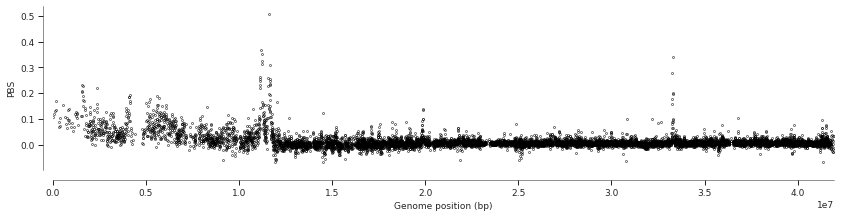

In [24]:
fig, ax = plt.subplots(figsize=(14, 3))
sns.despine(ax=ax, offset=10)
ax.plot(x, pbs, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
ax.set_xlabel('Genome position (bp)')
ax.set_xlim(0, pos.max())
ax.set_ylabel('PBS');


In [25]:
x[pbs >0.30]

array([11166928, 11208561, 11218930, 11241787, 11590959, 11643851,
       33282415], dtype=int32)

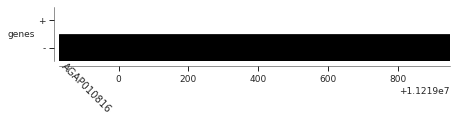

In [149]:
plot_genes(genome, geneset_fn, '3L', 11218830, 11219950, label=True, label_rotation=45, height=0.5)

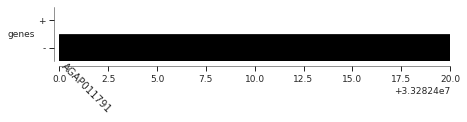

In [148]:
plot_genes(genome, geneset_fn, '3L', 33282400, 33282420, label=True, label_rotation=45, height=0.5)

Found these genes with PBS value above 0.30:
   - Gene: AGAP010816, Protein TEP3 - SNP Position 11218930
   - Gene: AGAP011791, Protein CLIPA1 - SNP Position 33282415

------------------------

In [164]:
def geneset_remastered(chrom, pos):   
    genes = get_geneset_features(geneset_fn, chrom, pos-100, pos+100).eq('type', 'gene').records()
    return genes

In [165]:
geneset_remastered('3L', 11218930)

('3L', 'VectorBase', 'gene', 11215246, 11220064, '.', '-', '.', {'ID': 'AGAP010816', 'biotype': 'protein_coding'})

In [228]:
def geneset_pbs(chrom, pop1, pop2, pop3):
    
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > 0.25]
    tbl=[]
    for i in range(len(over30)):

        a = get_geneset_features(geneset_fn, chrom, over30[i]-100, over30[i]+100).eq('type', 'gene').records()
        tbl.append(a)

    return tbl

In [229]:
asd = geneset_pbs('3R', 'BFgam', 'BFcol', 'arab')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [230]:
asd

[('3R', 'VectorBase', 'gene', 82151, 142545, '.', '+', '.', {'ID': 'AGAP007736', 'biotype': 'protein_coding'}),
 ('3R', 'VectorBase', 'gene', 82151, 142545, '.', '+', '.', {'ID': 'AGAP007736', 'biotype': 'protein_coding'}),
 ,
 ('3R', 'VectorBase', 'gene', 38137217, 38154470, '.', '+', '.', {'ID': 'AGAP009670', 'biotype': 'protein_coding'}),
 ,
 ,
 ('3R', 'VectorBase', 'gene', 43667301, 43668635, '.', '-', '.', {'ID': 'AGAP009802', 'biotype': 'protein_coding'}),
 ('3R', 'VectorBase', 'gene', 43676455, 43697706, '.', '-', '.', {'ID': 'AGAP009805', 'biotype': 'protein_coding'}),
 ('3R', 'VectorBase', 'gene', 43676455, 43697706, '.', '-', '.', {'ID': 'AGAP009805', 'biotype': 'protein_coding'}),
 ,
 ,
 ]

In [133]:
def plot_genes_remastered(chrom, pos):
    plot_genes(genome, geneset_fn, chrom, pos-100, pos+100, label=True, label_rotation=45, height=0.5)

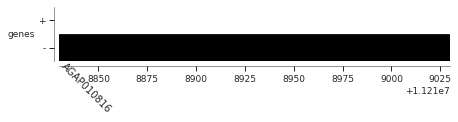

In [134]:
plot_genes_remastered('3L', 11218930)

In [120]:
def plot_genes_remastered(chrom, pos):
    plot_genes(genome, geneset_fn, chrom, pos-100, pos+100, label=True, label_rotation=45, height=0.5)

In [121]:
def plot_genes_pbs(chrom, pop1, pop2, pop3):
    
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > 0.25]
    print (over30)
    for i in range(len(over30)):
        plt.figure()
        plot_genes_remastered(chrom, over30[i])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


[  111880   121212   272465 38146011 39472026 40258889 43668516 43687557
 43691476 47942907 49112203 49721608]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

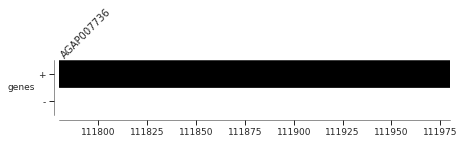

<Figure size 432x288 with 0 Axes>

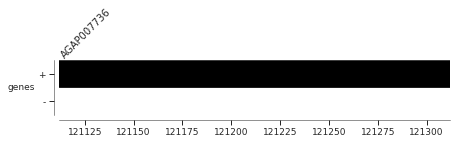

<Figure size 432x288 with 0 Axes>

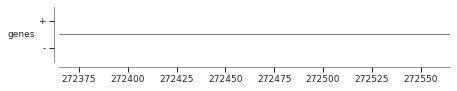

<Figure size 432x288 with 0 Axes>

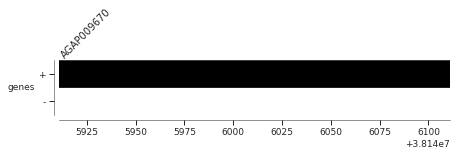

<Figure size 432x288 with 0 Axes>

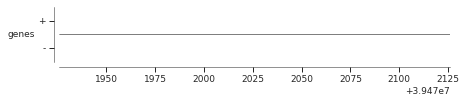

<Figure size 432x288 with 0 Axes>

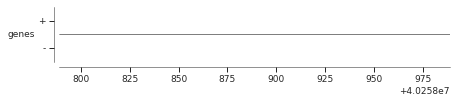

<Figure size 432x288 with 0 Axes>

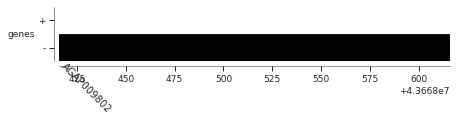

<Figure size 432x288 with 0 Axes>

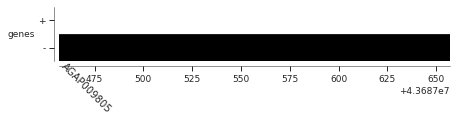

<Figure size 432x288 with 0 Axes>

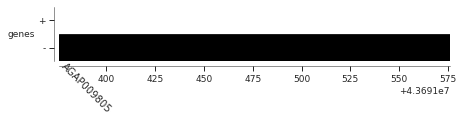

<Figure size 432x288 with 0 Axes>

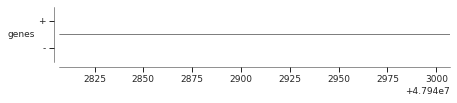

<Figure size 432x288 with 0 Axes>

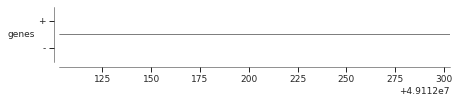

<Figure size 432x288 with 0 Axes>

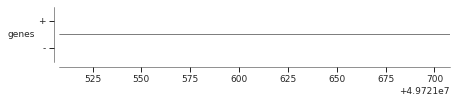

In [122]:
plot_genes_pbs('3R', 'BFgam', 'BFcol', 'arab')

-------------------------

In [140]:
import gffpandas.gffpandas as gffpd

In [146]:
col_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
df = pd.read_csv('/home/jovyan/notebooks/data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.sorted.gff3.gz', compression='gzip',
                         sep='\t', comment='#', low_memory=False,
                         header=None, names=col_names)


In [147]:
df

,seqid,source,type,start,end,score,strand,phase,attributes
0,2L,VectorBase,contig,1,49364325,.,.,.,ID=2L;molecule_type=dsDNA;translation_table=1;...
1,2L,VectorBase,exon,157348,157623,.,-,.,ID=AGAP004677-RB-E4A;Parent=AGAP004677-RA
2,2L,VectorBase,exon,157348,157623,.,-,.,ID=AGAP004677-RB-E4B;Parent=AGAP004677-RB
3,2L,VectorBase,gene,157348,186936,.,-,.,ID=AGAP004677;biotype=protein_coding
4,2L,VectorBase,mRNA,157348,181305,.,-,.,ID=AGAP004677-RA;Parent=AGAP004677;Dbxref=RefS...
5,2L,VectorBase,mRNA,157348,186936,.,-,.,ID=AGAP004677-RB;Parent=AGAP004677;Dbxref=RefS...
6,2L,VectorBase,three_prime_UTR,157348,157495,.,-,.,Parent=AGAP004677-RA
7,2L,VectorBase,three_prime_UTR,157348,157495,.,-,.,Parent=AGAP004677-RB
8,2L,VectorBase,CDS,157496,157623,.,-,2,Parent=AGAP004677-RA
9,2L,VectorBase,CDS,157496,157623,.,-,2,Parent=AGAP004677-RB
